# Deep Learning
## HW5 - Generative Adversarial Networks

---

Name: 

Student No.: 

---

**!!! CAUTION !!!**

* Please **remove the in training generated images** when you want to upload your assignment; but **keep the "Final Visualization"** section outputs.


In [1]:
!pip install gpustat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 1.7 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.7/84.7 kB 4.6 MB/s eta 0:00:00
  Created wheel for gpustat: filename=gpustat-1.1.1-py3-none-any.whl size=26720 sha256=e942ed29e46bf890fed501fe5bf49dc8db622823b8e18074afa1aad43a97a6b8
  Stored in directory: /root/.cache/pip/wheels/c9/2b/d9/a0b77d6e8623ce6b5c73813af455a3ace394abfc2e8aef7ed6
Successfully built gpustat


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from tqdm.auto import tqdm

%matplotlib inline

In [3]:
CUDA = True

device = torch.device("cuda:0" if CUDA else "cpu")

In [4]:
# Reproducibility options

np.random.seed(0)
torch.manual_seed(0)

if CUDA:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 1) Auxiliary Modules

In [5]:
class Reshape(nn.Module):
  """
  This module reshapes its input to `new_shape`
  """
  def __init__(self, new_shape):
    super().__init__()
    self.new_shape = new_shape

  def forward(self, x):
    return x.view(-1, *self.new_shape)

class NoiseGenerator(nn.Module):
  """
  This module generates `n` noises with `z_dim` dim from Normal distribution.
  """
  def __init__(self, z_dim):
    super().__init__()
    self.z_dim = z_dim

  def forward(self, n):
    noise = torch.randn(n, *self.z_dim).to(device)
    return noise

# 2) GAN Training Structure (14 points)

Complete the following class to define the GAN training structure.

In [9]:
class GANTrainer:
  """
  This class wraps the GAN training structure.

  Some arguments: \n
  `visualization_helper_fn`: Used to visualize model outputs at the end of each epoch. \n
  `G_loss_mode`: `{"logD" | "log(1-D)"}` Controls the loss function of the `generator`. \n
  `generator`: The generator. \n
  `discriminator`: The discriminator. The last layer is a LINEAR layer. \n
  """
  def __init__(self, train_dataloader:torch.utils.data.DataLoader, test_dataloader:torch.utils.data.DataLoader,
               noise_generator:NoiseGenerator, generator:nn.Module, discriminator:nn.Module,
               G_lr, D_lr,
               visualization_helper_fn, G_loss_mode):
    self.train_dataloader = train_dataloader
    self.test_dataloader = test_dataloader

    self.noise_generator = noise_generator.to(device)
    self.generator = generator.to(device)
    self.discriminator = discriminator.to(device)

    self.visualization_helper_fn = visualization_helper_fn
    self.G_loss_mode = G_loss_mode
    
    #################### Problem 01 (1 points) ####################
    # Define Adam optimizers with `G_lr` and `D_lr` learning rates.
    ####################################################
    
    self.opt_G = optim.Adam(self.generator.parameters(), lr=G_lr)
    self.opt_D = optim.Adam(self.discriminator.parameters(), lr=D_lr)
    ####################### End ########################

  def generate_samples(self, n):
    """
    This function generates `n` samples.
    """
    #################### Problem 02 (1 points) ####################
    # 1) Generate `n` noises
    # 1) Transform noises to samples
    ####################################################
    noise = self.noise_generator(n)
    fake_samples = self.generator(noise)
    ####################### End ########################
    return noise, fake_samples

  def G_step(self, n):
    """
    This function calculates `generator`'s loss for `n` samples.
    """
    #################### Problem 03 (1 points) ####################
    # 1) Generate `n` fake samples. put them in `x_fake`
    # 2) Compute discriminator `logits` for generated samples
    ####################################################
    noise, x_fake = self.generate_samples(n)
    logits = self.discriminator(x_fake)
    ####################### End ########################

    if self.G_loss_mode == 'logD':
      #################### Problem 04 (2 points) ####################
      # Compute the `generator`'s loss when using `logD` as an objective.
      # `loss = mean(...)`
      #
      # CAUTION!!!!! --->>>> PAY ATTENTION TO THE SIGN OF LOSS
      ####################################################
      loss = -torch.mean(F.logsigmoid(logits))
      ####################### End ########################

    elif self.G_loss_mode == 'log(1-D)':
      #################### Problem 05 (2 points) ####################
      # Compute the `generator`'s loss when using `log(1-D)` as an objective.
      # `loss = mean(...)`
      #
      # CAUTION!!!!! --->>>> PAY ATTENTION TO THE SIGN OF LOSS
      ####################################################
      loss = torch.mean(F.logsigmoid(-logits)) # todo dont understand ...
      ####################### End ########################

    else:
      raise BaseException('Invalid generator train mode!!')
      
    return loss, x_fake

  def D_step(self, x_real):
    """
    This function calculates `discriminator`'s loss for `x_real` and `x_fake`.
    """
    #################### Problem 06 (1 points) ####################
    # 1) Generate `n` fake samples. What is the value of `n`? why?
    #  put them in `x_fake`
    # 2) Detach the generated samples. why?
    ####################################################
    noise, x_fake = self.generate_samples(x_real.size(0))
    x_fake = x_fake.detach()
    ####################### End ########################

    #################### Problem 07 (2 points) ####################
    # Compute discriminator `loss` for `x_real` and `x_fake`. 
    # `loss = mean(...)`
    ####################################################
    # todo not sure whats happening
    logits_real = self.discriminator(x_real)
    logits_fake = self.discriminator(x_fake)
    loss_real = -torch.mean(F.logsigmoid(logits_real))
    loss_fake = -torch.mean(F.logsigmoid(-logits_fake))
    loss = loss_real + loss_fake
    ####################### End ########################

    return loss

  def train_loop(self, epoch, G_update_times, D_update_times, verbose=True):
    """
    This function iterates over `train_dataloader` and trains 
    `generator` and `discriminator` for ONE epoch.

    Some arguments: \n
    `G_update_times`: how many times to update `generator` on each batch \n
    `D_update_times`: how many times to update `discriminator` on each batch \n
    """
    train_G_loss = 0
    train_D_loss = 0

    for batch_idx, (x, _) in enumerate(tqdm(self.train_dataloader)):
      x = x.to(device)

      for _ in range(D_update_times):
        #################### Problem 08 (1 points) ####################
        # 1) Put `generator` in `eval` mode
        # 2) Put `discriminator` in `train` mode
        # 3) Zero out `opt_D`'s gradients
        # 4) Compute `discriminator`'s loss (`D_loss`); use `D_step`
        # 5) Backpropagate `D_loss`
        # 6) Update ``discriminator` parameters
        ####################################################
        self.generator.eval()
        self.discriminator.train()
        self.opt_D.zero_grad()
        D_loss = self.D_step(x)
        D_loss.backward() 
        self.opt_D.step()
        ####################### End ########################

      for _ in range(G_update_times):
        #################### Problem 09 (1 points) ####################
        # 1) Put `generator` in `train` mode
        # 2) Put `discriminator` in `eval` mode
        # 3) Zero out `opt_G`'s gradients
        # 4) Compute `generator`'s loss (`G_loss`); use `G_step`
        # 5) Backpropagate `G_loss`
        # 6) Update `generator` parameters
        ####################################################
        self.generator.train()
        self.discriminator.eval()
        self.opt_G.zero_grad()
        G_loss, _ = self.G_step(x.size(0))
        G_loss.backward() 
        self.opt_G.step()
        ####################### End ########################
      
      train_D_loss += D_loss.item() * x.shape[0]
      train_G_loss += G_loss.item() * x.shape[0]

      if verbose and batch_idx % LOG_INTERVAL == 0:
          print('Train | Epoch: {} [{}/{}]\t\tD-Loss: {:.6f}\tG-Loss: {:.6f}'
          .format(epoch, batch_idx * len(x), len(self.train_dataloader) * BATCH_SIZE, D_loss, G_loss))

    train_D_loss /= len(self.train_dataloader) * BATCH_SIZE
    train_G_loss /= len(self.train_dataloader) * BATCH_SIZE
    if verbose:
        print('====> Train | Epoch: {} \t | \tAverage D-loss: {:.4f} \t | \tAverage G-loss: {:.4f}'.format(epoch, train_D_loss, train_G_loss,))
    return train_G_loss, train_D_loss
  
  def test(self, verbose=True):
    """
    This function iterates over `test_dataloader` and
    reports `generator` and `discriminator` losses.
    """
    self.discriminator.eval()
    self.generator.eval()

    test_G_loss = 0
    test_D_loss = 0

    with torch.no_grad():
      for x, _ in self.test_dataloader:
        x = x.to(device)

        #################### Problem 10 (1 points) ####################
        # 1) Put `generator` in `eval` mode
        # 2) Put `discriminator` in `train` mode
        # 4) Compute `discriminator`'s loss; use `D_step`
        ####################################################
        self.generator.eval()
        self.discriminator.train()
        D_loss = self.D_step(x)
        ####################### End ########################

        #################### Problem 11 (1 points) ####################
        # 1) Put `generator` in `train` mode
        # 2) Put `discriminator` in `eval` mode
        # 4) Compute `generator`'s loss; use `G_step(n)` where `n = x.shape[0]`
        ####################################################
        self.generator.train()
        self.discriminator.eval()
        G_loss, _ = self.G_step(x.size(0))
        ####################### End ########################

        test_D_loss += D_loss.item() * x.shape[0]
        test_G_loss += G_loss.item() * x.shape[0]

            
    test_D_loss /= len(self.test_dataloader) * BATCH_SIZE
    test_G_loss /= len(self.test_dataloader) * BATCH_SIZE
    if verbose:
      print('====> Test | Average D-loss: {:.4f} \t | \tAverage G-loss: {:.4f}'.format(test_D_loss, test_G_loss,))
    return test_G_loss, test_D_loss

  def run(self, n_epoch, G_update_times=1, D_update_times=1, verbose=True):
    """
    This function will optimize parameters of `generator` and `discriminator`
    for `n_epoch` epochs on `train_dataloader` dataset and validate it on
    `test_dataloader`. At the end of each epoch, `visualization_helper_fn`
    will be called to visualize the GAN behavior.


    Some arguments: \n
    `G_update_times`: how many times to update `generator` on each batch \n
    `D_update_times`: how many times to update `discriminator` on each batch \n
    """
    !gpustat
    for epoch in range(1, n_epoch + 1):
        self.train_loop(epoch, G_update_times, D_update_times, verbose)
        self.test(verbose)
        self.visualization_helper_fn(self)
        if epoch == 1:
          !gpustat


---

# 3) Part 1 - 2D Toy Dataset

In the first part, we will learn density of toy datasets to examine GAN training.

## 3.1) Helper functions
These are functions used in visulization.

In [8]:
def toy2d_density_plot(samples, title, ax=None):
  """
  This function plots the distribution of `samples`.
  """
  fig = None
  if ax is None:
    fig, ax = plt.subplots(1, figsize=(3, 3))

  samples = samples.detach().cpu().numpy()
  sns.kdeplot(x=samples[:, 0], y=samples[:, 1], fill=True, ax=ax)
  ax.set_title(title)

  if fig is not None:
    plt.show()

In [9]:
def toy2d_decision_boundary_plot(samples, labels, title, ax=None):
  """
  This function plots regions corresponding to each label value. Can be used to
  understand the decision boundary of `discriminator`.
  """
  fig = None
  if ax is None:
    fig, ax = plt.subplots(1, figsize=(3, 3))

  samples = samples.detach().cpu().numpy()
  labels = labels.detach().cpu().numpy()

  sns.scatterplot(
      x=samples[:, 0],
      y=samples[:, 1],
      hue=labels,
      legend='brief',
      marker='.',
      ax=ax
      )
  ax.set_title(title)

  if fig is not None:
    plt.show()

In [10]:
def toy2d_visualization_helper_fn(trainer: GANTrainer):
  """
  Used to visualize generator's distribution and 
  discriminator's decision boundary.
  """
  rows = 1
  cols = 2
  fig, axs = plt.subplots(rows, cols, squeeze=False, figsize=(3 * cols, 3 * rows))

  _, fake_samples = trainer.generate_samples(10000)
  random_samples = (torch.rand((10000, 2)) - .5) * 3 * R
  random_samples = random_samples.to(device)
  with torch.no_grad():
    disc_labels = torch.sigmoid(trainer.discriminator(random_samples))[:, 0]
  
  toy2d_density_plot(fake_samples, 'generator distribution', axs[0][0])
  toy2d_decision_boundary_plot(random_samples, disc_labels, 'discriminator decision boundary', axs[0][1])

  plt.show()

## 3.2) Defining Toy Datasets

In [11]:
class Toy2dCircularGaussiansDataset(torch.utils.data.Dataset):
  """
  This dataset puts 'n_modes` gaussians on a circle with 'r' radius.
  """
  def __init__(self, r=10, std_dev=1, n_modes=20, n_samples=10000):
    self.r = r
    self.std_dev = std_dev
    self.n_modes = n_modes
    
    self.mode_ids = torch.randint(high=self.n_modes, size=(n_samples,))
    theta = 2 * np.pi / n_modes * self.mode_ids
    mu = self.r * torch.stack([torch.cos(theta), torch.sin(theta)], dim=1)
    self.samples = torch.randn((n_samples, 2)) * self.std_dev + mu
  
  def __getitem__(self, i):  
    return self.samples[i], self.mode_ids[i]

  def __len__(self):
    return self.samples.shape[0]

In [12]:
class Toy2dGridGaussiansDataset(torch.utils.data.Dataset):
  """
  This dataset puts 'n_modes^2` gaussians on a grid with '2r' width and height.
  """
  def __init__(self, r=1, std_dev=1, n_modes=5, n_samples=10000):
    self.r = r
    self.std_dev = std_dev
    self.n_modes = n_modes
    assert n_modes >= 2
    
    self.mode_ids = torch.randint(high=self.n_modes, size=(n_samples, 2))
    mu = self.mode_ids * (2 * self.r / (self.n_modes - 1)) - self.r
    self.samples = torch.randn((n_samples, 2)) * self.std_dev + mu
  
  def __getitem__(self, i):  
    return self.samples[i], self.mode_ids[i]

  def __len__(self):
    return self.samples.shape[0]

## 3.3) Dataset Loading


You can load either `Toy2dCircularGaussiansDataset` or `Toy2dGridGaussiansDataset` to play with it; but the question at the end of this part is for the `Toy2dGridGaussiansDataset` dataset.

In [13]:
# parameters of toy dataset
TRAIN_SIZE = 60000
TEST_SIZE = 10000
R = 1

# ############### To use `Toy2dCircularGaussiansDataset` ############### #
# N_MODES = 8
# STD_DEV = 25e-3
# toy2d_train_dataset = Toy2dCircularGaussiansDataset(R, STD_DEV, N_MODES, TRAIN_SIZE)
# toy2d_test_dataset = Toy2dCircularGaussiansDataset(R, STD_DEV, N_MODES, TEST_SIZE)
# ###################################################################### #

# ################# To use `Toy2dGridGaussiansDataset` ################# #
N_MODES = 4
STD_DEV = 25e-3
toy2d_train_dataset = Toy2dGridGaussiansDataset(R, STD_DEV, N_MODES, TRAIN_SIZE)
toy2d_test_dataset = Toy2dGridGaussiansDataset(R, STD_DEV, N_MODES, TEST_SIZE)
# ###################################################################### #

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


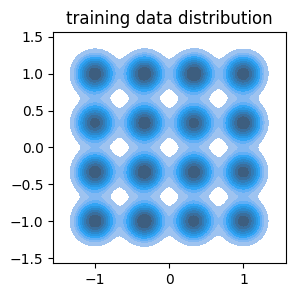

In [14]:
# Plotting dataset distribution to see it :)

toy2d_density_plot(toy2d_train_dataset[:10000][0], 'training data distribution')

## 3.4) Defining Models (4 points)

In [28]:
# Generator part
#################### Problem 12 (2 points) ####################
# 1) Define `toy2d_noise_generator`.
# 2) Define `toy2d_generator` network.
#    Use `Tanh` for intermediate layers.
#    Use `Linear` for the last layer.
####################################################
toy2d_noise_generator = NoiseGenerator((200, ))
toy2d_generator = nn.Sequential(
    nn.Linear(in_features=200, out_features=128, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=128, out_features=128, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=128, out_features=2, bias=True)
)
####################### End ########################

# Discriminator part
#################### Problem 13 (2 points) ####################
# 1) Define `toy2d_discriminator` network.
#    Use `Tanh` for intermediate layers.
#    Use `Linear` for the last layer. why?
####################################################
toy2d_discriminator = nn.Sequential(
    nn.Linear(in_features=2, out_features=128, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=128, out_features=128, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=128, out_features=1, bias=True)
)
####################### End ########################

toy2d_generator = toy2d_generator.to(device)
toy2d_discriminator = toy2d_discriminator.to(device)

print(toy2d_generator)
print(toy2d_discriminator)

Sequential(
  (0): Linear(in_features=200, out_features=128, bias=True)
  (1): Tanh()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): Tanh()
  (4): Linear(in_features=128, out_features=2, bias=True)
)
Sequential(
  (0): Linear(in_features=2, out_features=128, bias=True)
  (1): Tanh()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): Tanh()
  (4): Linear(in_features=128, out_features=1, bias=True)
)


## 3.5) Train

### 3.5.1) Batching Data

In [29]:
BATCH_SIZE = 1024

toy2d_dataloader_kwargs = {
    'batch_size': BATCH_SIZE, 
    'shuffle': True,
    'pin_memory': True,
    'num_workers': 0,
}

toy2d_train_dataloader = torch.utils.data.DataLoader(toy2d_train_dataset, **toy2d_dataloader_kwargs)
toy2d_test_dataloader = torch.utils.data.DataLoader(toy2d_test_dataset, **toy2d_dataloader_kwargs)

### 3.5.2) Run (2 points)

In [30]:
LOG_INTERVAL = 50
#################### Problem 14 (1 points) ####################
# Tune `generator` and `discriminator` learning rates
# and also the `G_LOSS_MODE`.
####################################################
TOY2D_G_LEARNING_RATE = 5e-4
TOY2D_D_LEARNING_RATE = 4e-4
G_LOSS_MODE = 'logD'
####################### End ########################

toy2d_trainer = GANTrainer(toy2d_train_dataloader, toy2d_test_dataloader,
                           toy2d_noise_generator, toy2d_generator, toy2d_discriminator,
                           TOY2D_G_LEARNING_RATE, TOY2D_D_LEARNING_RATE,
                           toy2d_visualization_helper_fn, G_LOSS_MODE)

In [ ]:
#################### Problem 15 (1 points) ####################
# Tune `n_epoch`, `G_update_times` and `D_update_times`
####################################################
n_epochs = 100
G_update_times = 1
D_update_times = 3
toy2d_trainer.run(n_epochs, G_update_times, D_update_times)
####################### End ########################

### 3.5.3) Final Visualization
It is an evaluating criteria for network architecture and parameter tuning (problems 12 to 15)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


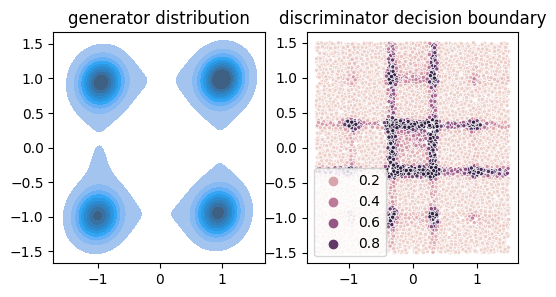

In [32]:
toy2d_visualization_helper_fn(toy2d_trainer)

## 3.6) Question (4 points)
Train GAN on `Toy2dGridGaussiansDataset` dataset for ENOUGH epochs.
We hope that our desired problem has occured for your model :)

Is the generator successful to learn the entire target distribution? 

No—the generator did not learn the entire target distribution. It concentrated its samples on a small subset of the Gaussians and occasionally “hopped” to a different subset across epochs.

* (3 points) Define the *\"Mode Collapse\"* problem of GANs.

Mode collapse happens when a GAN’s generator maps many different latent inputs z to the same (or very similar) outputs, covering only a few modes of the true data distribution and ignoring the rest. Concretely on the grid-of-Gaussians dataset: 
Instead of placing points on all grid cells, the generator puts most samples on one/few cells (or a narrow stripe/cluster).
Over training, the generator may cycle: jumping from one subset of modes to another, but still failing to cover them simultaneously.


* (1 points) Why do you think this problem happens?

Generator can win by exploiting a few easy modes. The generator only receives gradients through the discriminator on the current minibatch; the quickest way to increase the objective is to push probability mass to places where D is weak—often a single high-density region—rather than spreading mass across all modes. There’s no direct term that rewards coverage. 

With the original GAN objective, when the supports of p_data and p_G are disjoint or partially overlapping, gradients can vanish or point toward closest high-density regions, not toward covering missing modes. This biases training toward a few modes.


# 4) Part 2 - MNIST

In the second part, we will learn to generate MNIST like samples.

## 4.1) Helper functions
These are functions used in visulization.

In [10]:
def vector_linspace(start, end, steps):
  """
  Vector version of torch linspace
  """
  result = []
  for dim in range(start.shape[0]):
    result.append(torch.linspace(start[dim], end[dim], steps))
  result = torch.stack(result, dim=1).to(device)
  return result

In [11]:
def mnist_show(image_batch, rows=1):
  """
  This function gets multiple MNIST images and plots them in the given number of rows.
  """
  image_batch = image_batch.detach().cpu()
  image_batch = image_batch.view(-1, 28, 28)
  image_batch = image_batch.numpy()

  cols = int(np.ceil(image_batch.shape[0] / rows))
  plt.rcParams['figure.figsize'] = (cols, rows) # set default size of plots  
  
  for i in range(image_batch.shape[0]):
      plt.subplot(rows, cols, i + 1)
      plt.imshow(image_batch[i], cmap="gray", vmin=0, vmax=1)
      plt.axis('off')
  plt.show()

In [12]:
def mnist_visualization_helper_fn(trainer: GANTrainer):
  """
  Generates fake samples and plots them for you.
  """
  _, fake_samples = trainer.generate_samples(30)
  mnist_show(fake_samples, 3)

In [13]:
def show_interpolations(trainer:GANTrainer, n_rows, n_cols):
    """
    Shows image interpolation (grid of [`n_rows`, `n_cols`]) in input noise space.
    """
    anchor_noises = trainer.noise_generator(4)
    left_column = vector_linspace(anchor_noises[0], anchor_noises[1], n_rows)
    right_column = vector_linspace(anchor_noises[2], anchor_noises[3], n_rows)
    rows = []
    for i in range(n_rows):
      rows.append(vector_linspace(left_column[i], right_column[i], n_cols))
    noises = torch.stack(rows, dim=0).view(n_rows * n_cols, -1)
    with torch.no_grad():
      fake_imgs = trainer.generator(noises)
    mnist_show(fake_imgs, n_rows)

## 4.2) Dataset Loading

In [14]:
# Get MNIST dataloader

mnist_dataset_kwargs = {
    'download': True,
    'transform': transforms.Compose([
                                     transforms.ToTensor(),
                                     lambda img: img * 2 - 1, # to make pixel values between [-1, 1]
                                    #  lambda img: torch.transpose(img, 1, 2)
                                     ])
}

mnist_train_dataset = datasets.MNIST('./data', train=True, **mnist_dataset_kwargs)
mnist_test_dataset = datasets.MNIST('./data', train=False, **mnist_dataset_kwargs)

print(len(mnist_train_dataset))

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 161kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.78MB/s]

60000


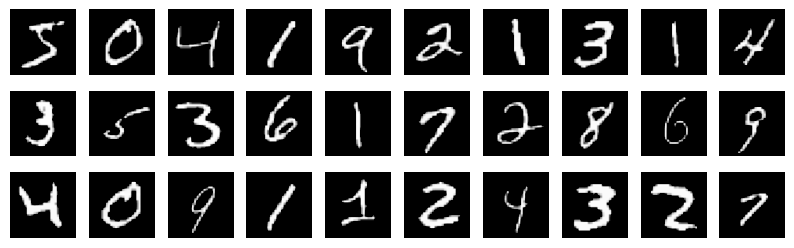

In [15]:
temp = torch.stack([mnist_train_dataset[i][0] for i in range(30)], dim=0)
mnist_show(temp, 3)

## 4.3) Defining Models (6 points)

In [16]:
def print_layer_sizes(model , latent_size = 100):
    model.to(device)
    
    if latent_size is not None:
        a = torch.randn(2, latent_size).to(device)
    else:
        a = torch.randn(2, 1 , 28 , 28).to(device)
    for i in model:
        a = i(a)
        print (a.shape)

In [21]:
# Generator part
#################### Problem 16 (3 points) ####################
# 1) Define `mnist_noise_generator`.
# 2) Define `mnist_generator` network.
#    Use `LeakyReLU` for intermediate layers.
#    Use `Tanh` for the last layer.
#    Use convolution layers.
#    Can use batch norm, dropout, ...
####################################################
mnist_noise_generator = NoiseGenerator((100, 1, 1))
mnist_generator = nn.Sequential(
    Reshape((100, 1, 1)),
    
    nn.ConvTranspose2d(100, 256, kernel_size=7, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1, bias=False),
    nn.Tanh(),
)
####################### End ########################

# Discriminator part
#################### Problem 17 (3 points) ####################
# 1) Define `toy2d_discriminator` network.
#    Use `LeakyReLU` for intermediate layers.
#    Use `Linear` for the last layer. why?
#    Use convolution layers.
#    Can use batch norm, dropout, ...
####################################################

mnist_discriminator = nn.Sequential(

    nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Dropout(0.5),

   
    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Dropout(0.5),

  
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Dropout(0.5),

  
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Dropout(0.5),

    nn.Flatten(),                 # (B, 512*1*1)
    nn.Linear(512, 1, bias=True), # linear logit (no activation here)
)
####################### End ########################

mnist_generator = mnist_generator.to(device)
mnist_discriminator = mnist_discriminator.to(device)

print(mnist_generator)
print(mnist_discriminator)

Sequential(
  (0): Reshape()
  (1): ConvTranspose2d(100, 256, kernel_size=(7, 7), stride=(1, 1), bias=False)
  (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): LeakyReLU(negative_slope=0.2, inplace=True)
  (4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): LeakyReLU(negative_slope=0.2, inplace=True)
  (7): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): LeakyReLU(negative_slope=0.2, inplace=True)
  (10): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (11): Tanh()
)
Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Dropout(p=0.5, inplace=False

## 4.4) Train

### 4.4.1) Batching Data

you can use `train_sampler` and `test_sampler` to test your model on smaller subset of dataset; but, the final report must be on the whole dataset.

In [22]:
BATCH_SIZE = 256

mnist_dataloader_kwargs = {
    'batch_size': BATCH_SIZE, 
    'pin_memory': True,
    'num_workers': 0,
}

# ############### To use complete dataset ############### #

# ####################################################### #

# ############### To use subsample of dataset ############### #
train_sampler = torch.utils.data.RandomSampler(mnist_train_dataset, replacement=True, num_samples=10000)
test_sampler = torch.utils.data.RandomSampler(mnist_test_dataset, replacement=True, num_samples=2000)
mnist_dataloader_kwargs['shuffle'] = False
# ########################################################### #

mnist_train_dataloader = torch.utils.data.DataLoader(mnist_train_dataset, sampler=train_sampler, **mnist_dataloader_kwargs)
mnist_test_dataloader = torch.utils.data.DataLoader(mnist_test_dataset, sampler=test_sampler, **mnist_dataloader_kwargs)

### 4.4.2) Run (2 points)

In [25]:
LOG_INTERVAL = 50
#################### Problem 18 (1 points) ####################
# Tune `generator` and `discriminator` learning rates
# and also the `G_LOSS_MODE`.
####################################################
MNIST_G_LEARNING_RATE = 2e-4
MNIST_D_LEARNING_RATE = 1e-4
G_LOSS_MODE = 'logD'
####################### End ########################

mnist_trainer = GANTrainer(mnist_train_dataloader, mnist_test_dataloader,
                           mnist_noise_generator, mnist_generator, mnist_discriminator,
                           MNIST_G_LEARNING_RATE, MNIST_D_LEARNING_RATE,
                           mnist_visualization_helper_fn, G_LOSS_MODE)

In [ ]:
#################### Problem 19 (1 points) ####################
# Tune `n_epoch`, `G_update_times` and `D_update_times`
####################################################
n_epoch = 50
G_update_times = 1
D_update_times = 2
mnist_trainer.run(n_epoch, G_update_times, D_update_times)
####################### End ########################

### 4.4.3) Final Visualization
It is an evaluating criteria for network architecture and parameter tuning (problems 16 to 19)

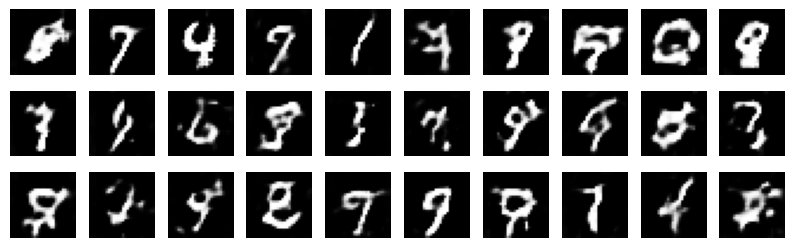

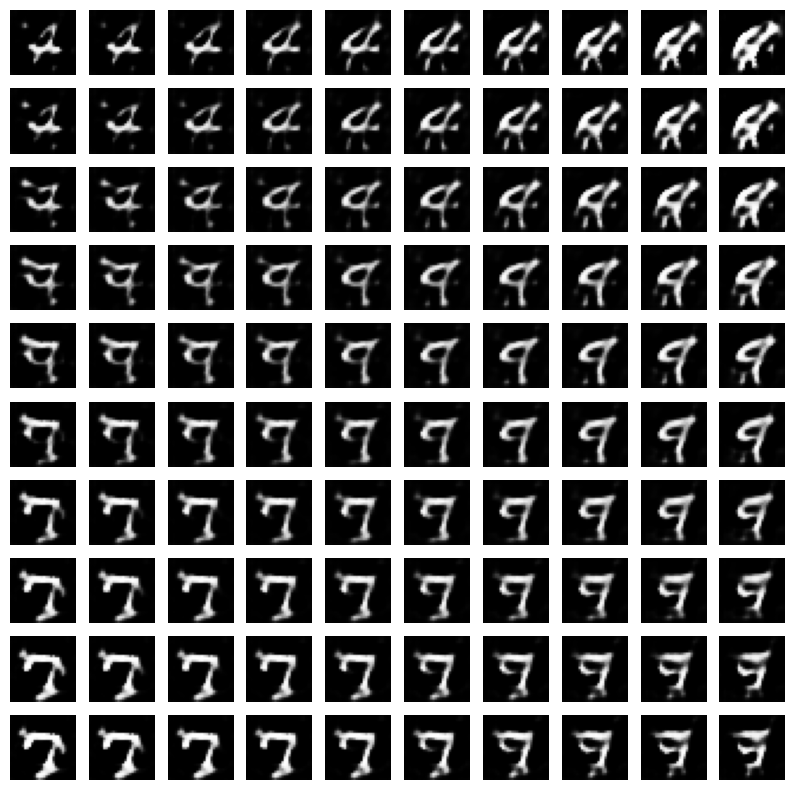

In [29]:
mnist_visualization_helper_fn(mnist_trainer)
show_interpolations(mnist_trainer, 10, 10)